### scrublet and QC
author: gw
date: 07252022
- reanalyzing human single-cell skeletl muscle data with scrublet

In [62]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc_context
import numpy as np
import seaborn as sns
import os
rcParams['svg.fonttype'] = 'none'

os.getcwd()

'/mnt/c/Users/Griffen/Desktop'

In [63]:
sc.set_figure_params(scanpy=True, frameon=False, format='svg', transparent=True, vector_friendly=True, figsize=[4,4], dpi=80, dpi_save=300, color_map='viridis_r')
#sc.logging.print_version_and_date()

In [64]:
# read raw data from 10x matrix
adata = sc.read_10x_mtx('Lab Projects and Data/Alasdair Muscle/alasdair_cellranger_outs/', cache=False)
adata.raw = adata.copy()

In [65]:
# prelim QC
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True, log1p=False, percent_top=False)
adata.shape

(2263, 17022)

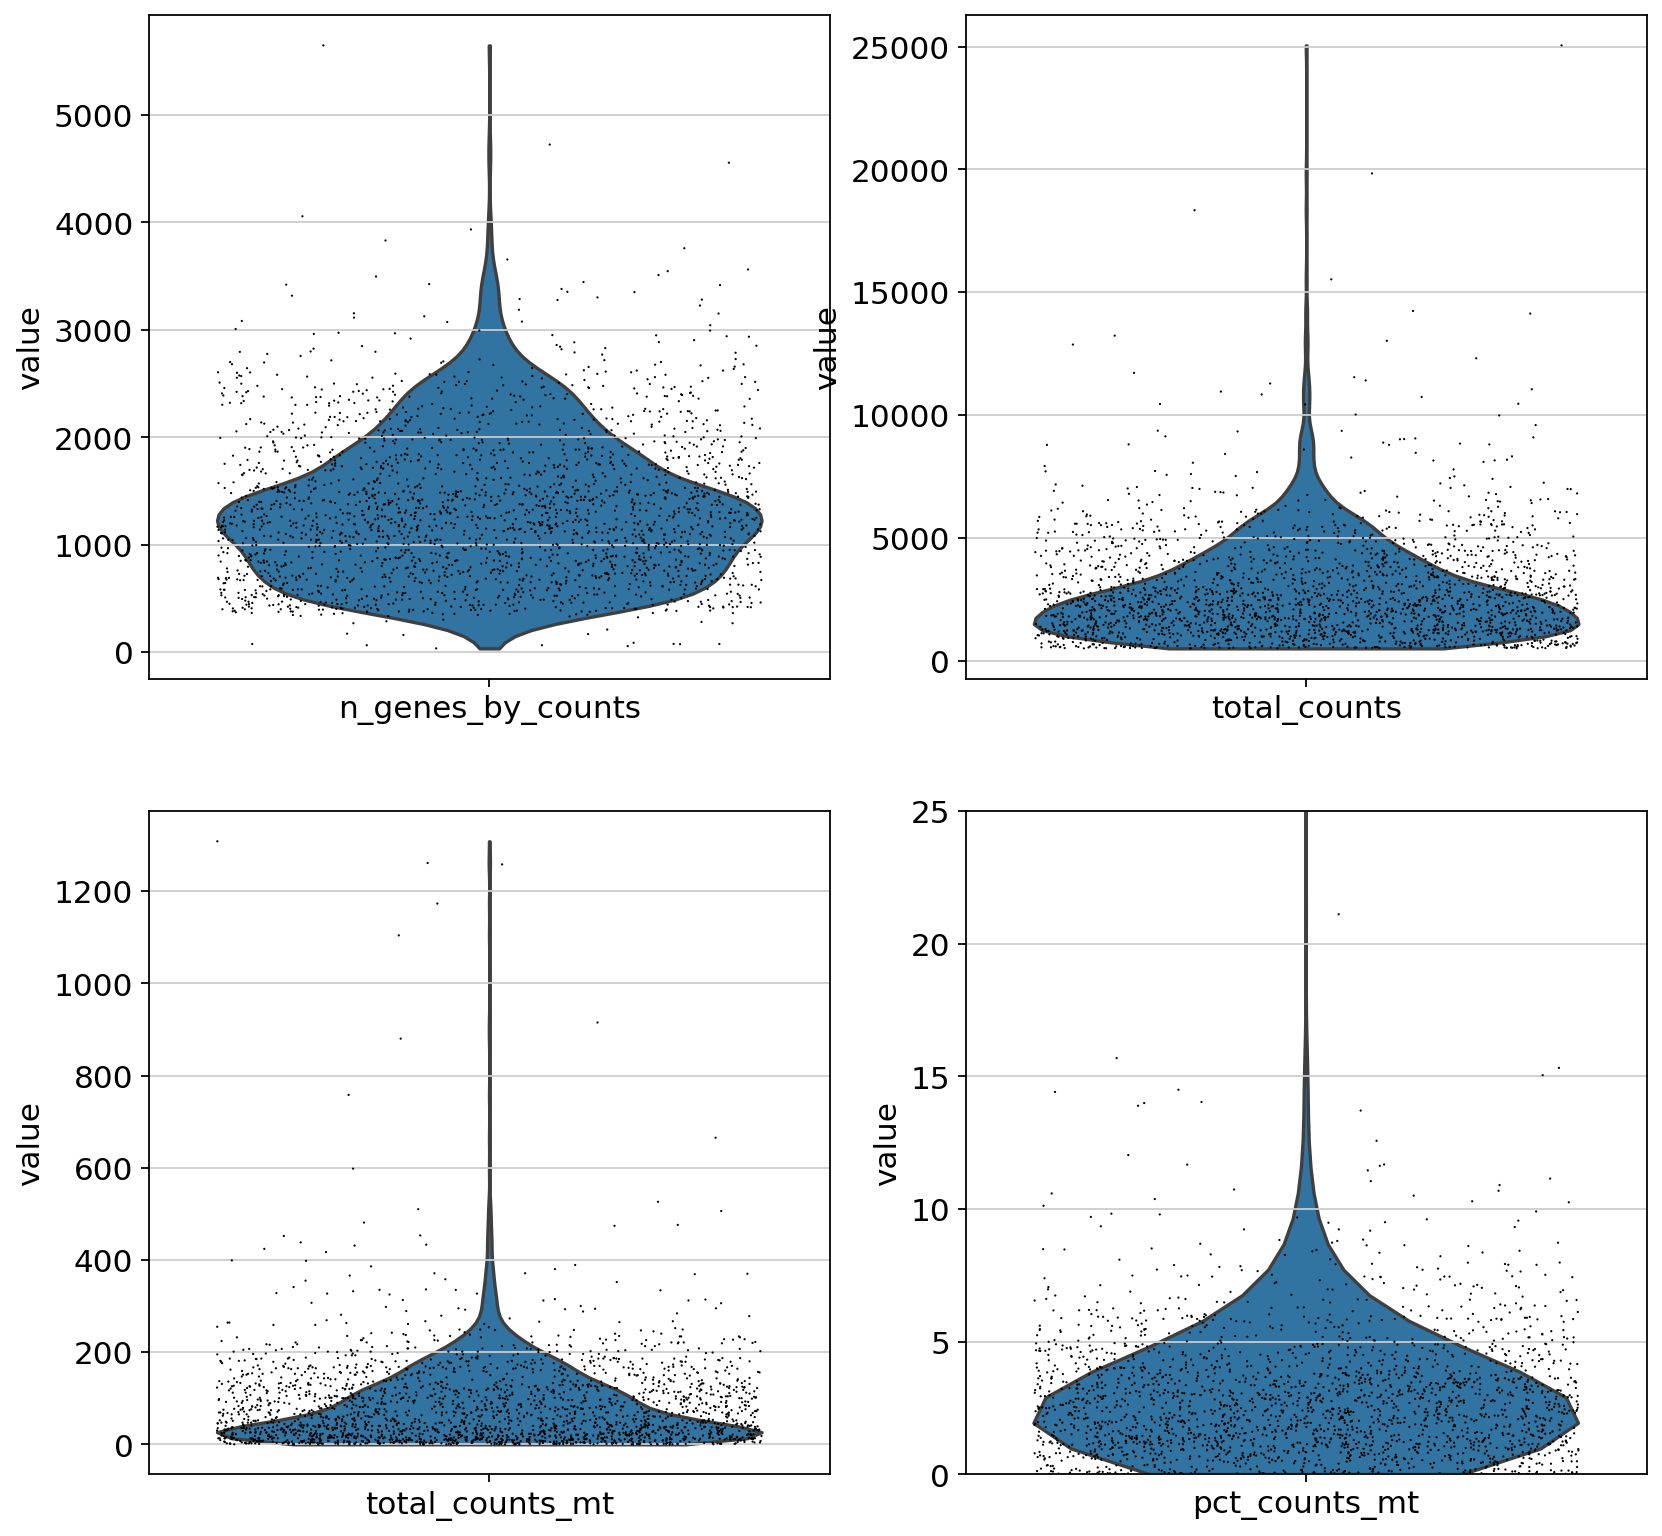

In [66]:
# general QC metrics
fig, ax = plt.subplots(2, 2, figsize=[12,12])
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, ax=ax[0,0], show=False)
sc.pl.violin(adata, ['total_counts'], jitter=0.4, ax=ax[0,1], show=False)
sc.pl.violin(adata, ['total_counts_mt'], jitter=0.4, ax=ax[1,0], show=False)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, ax=ax[1,1], show=False)
ax[1,1].set_ylim(0,25)
plt.show()

In [67]:
# choose fairly-conservative cutoffs for QC
adata = adata[adata.obs['n_genes_by_counts'] < 4000,:]
adata = adata[adata.obs['total_counts'] < 15000,:]
adata = adata[adata.obs['total_counts'] > 450, :]
adata = adata[adata.obs['pct_counts_mt'] < 15, :]

In [68]:
# run scrublet on data with default settings
sce.pp.scrublet(
    adata,
    adata_sim=None,
    batch_key=None,
    sim_doublet_ratio=2.0,
    expected_doublet_rate=0.05,
    stdev_doublet_rate=0.02,
    synthetic_doublet_umi_subsampling=1.0,
    knn_dist_metric='euclidean',
    normalize_variance=True,
    log_transform=False,
    mean_center=True,
    n_prin_comps=30,
    use_approx_neighbors=True,
    get_doublet_neighbor_parents=False,
    n_neighbors=np.round(0.5 * np.sqrt(adata.n_obs)),
    threshold=None,
    verbose=True,
    copy=False,
    random_state=995123
)

/home/griffen/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 19.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.0%


/home/griffen/miniconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/external/pp/_scrublet.py:271: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = scrubbed['obs']['doublet_score']


In [69]:
# standard processing workflow to see if doublets preferentially distribute into any specific clusters
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.0125, max_mean=3, n_top_genes=2000, flavor='cell_ranger', layer='counts', inplace=True, subset=False)
adata = adata[:,adata.var['highly_variable']]
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=True, random_state=8812375)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, knn=True, random_state=58812)
sc.tl.umap(adata, min_dist=0.3, spread=1, random_state=88123)
sc.tl.leiden(adata, resolution=0.5, random_state=45155)

In [70]:
# create bins at evey doublet score multiple of 0.1
for i in range(1,10):
    adata.obs[f'doublet_0.{i}'] = (adata.obs['doublet_score'] < float(f'0.{i}')).astype(str).astype('category')

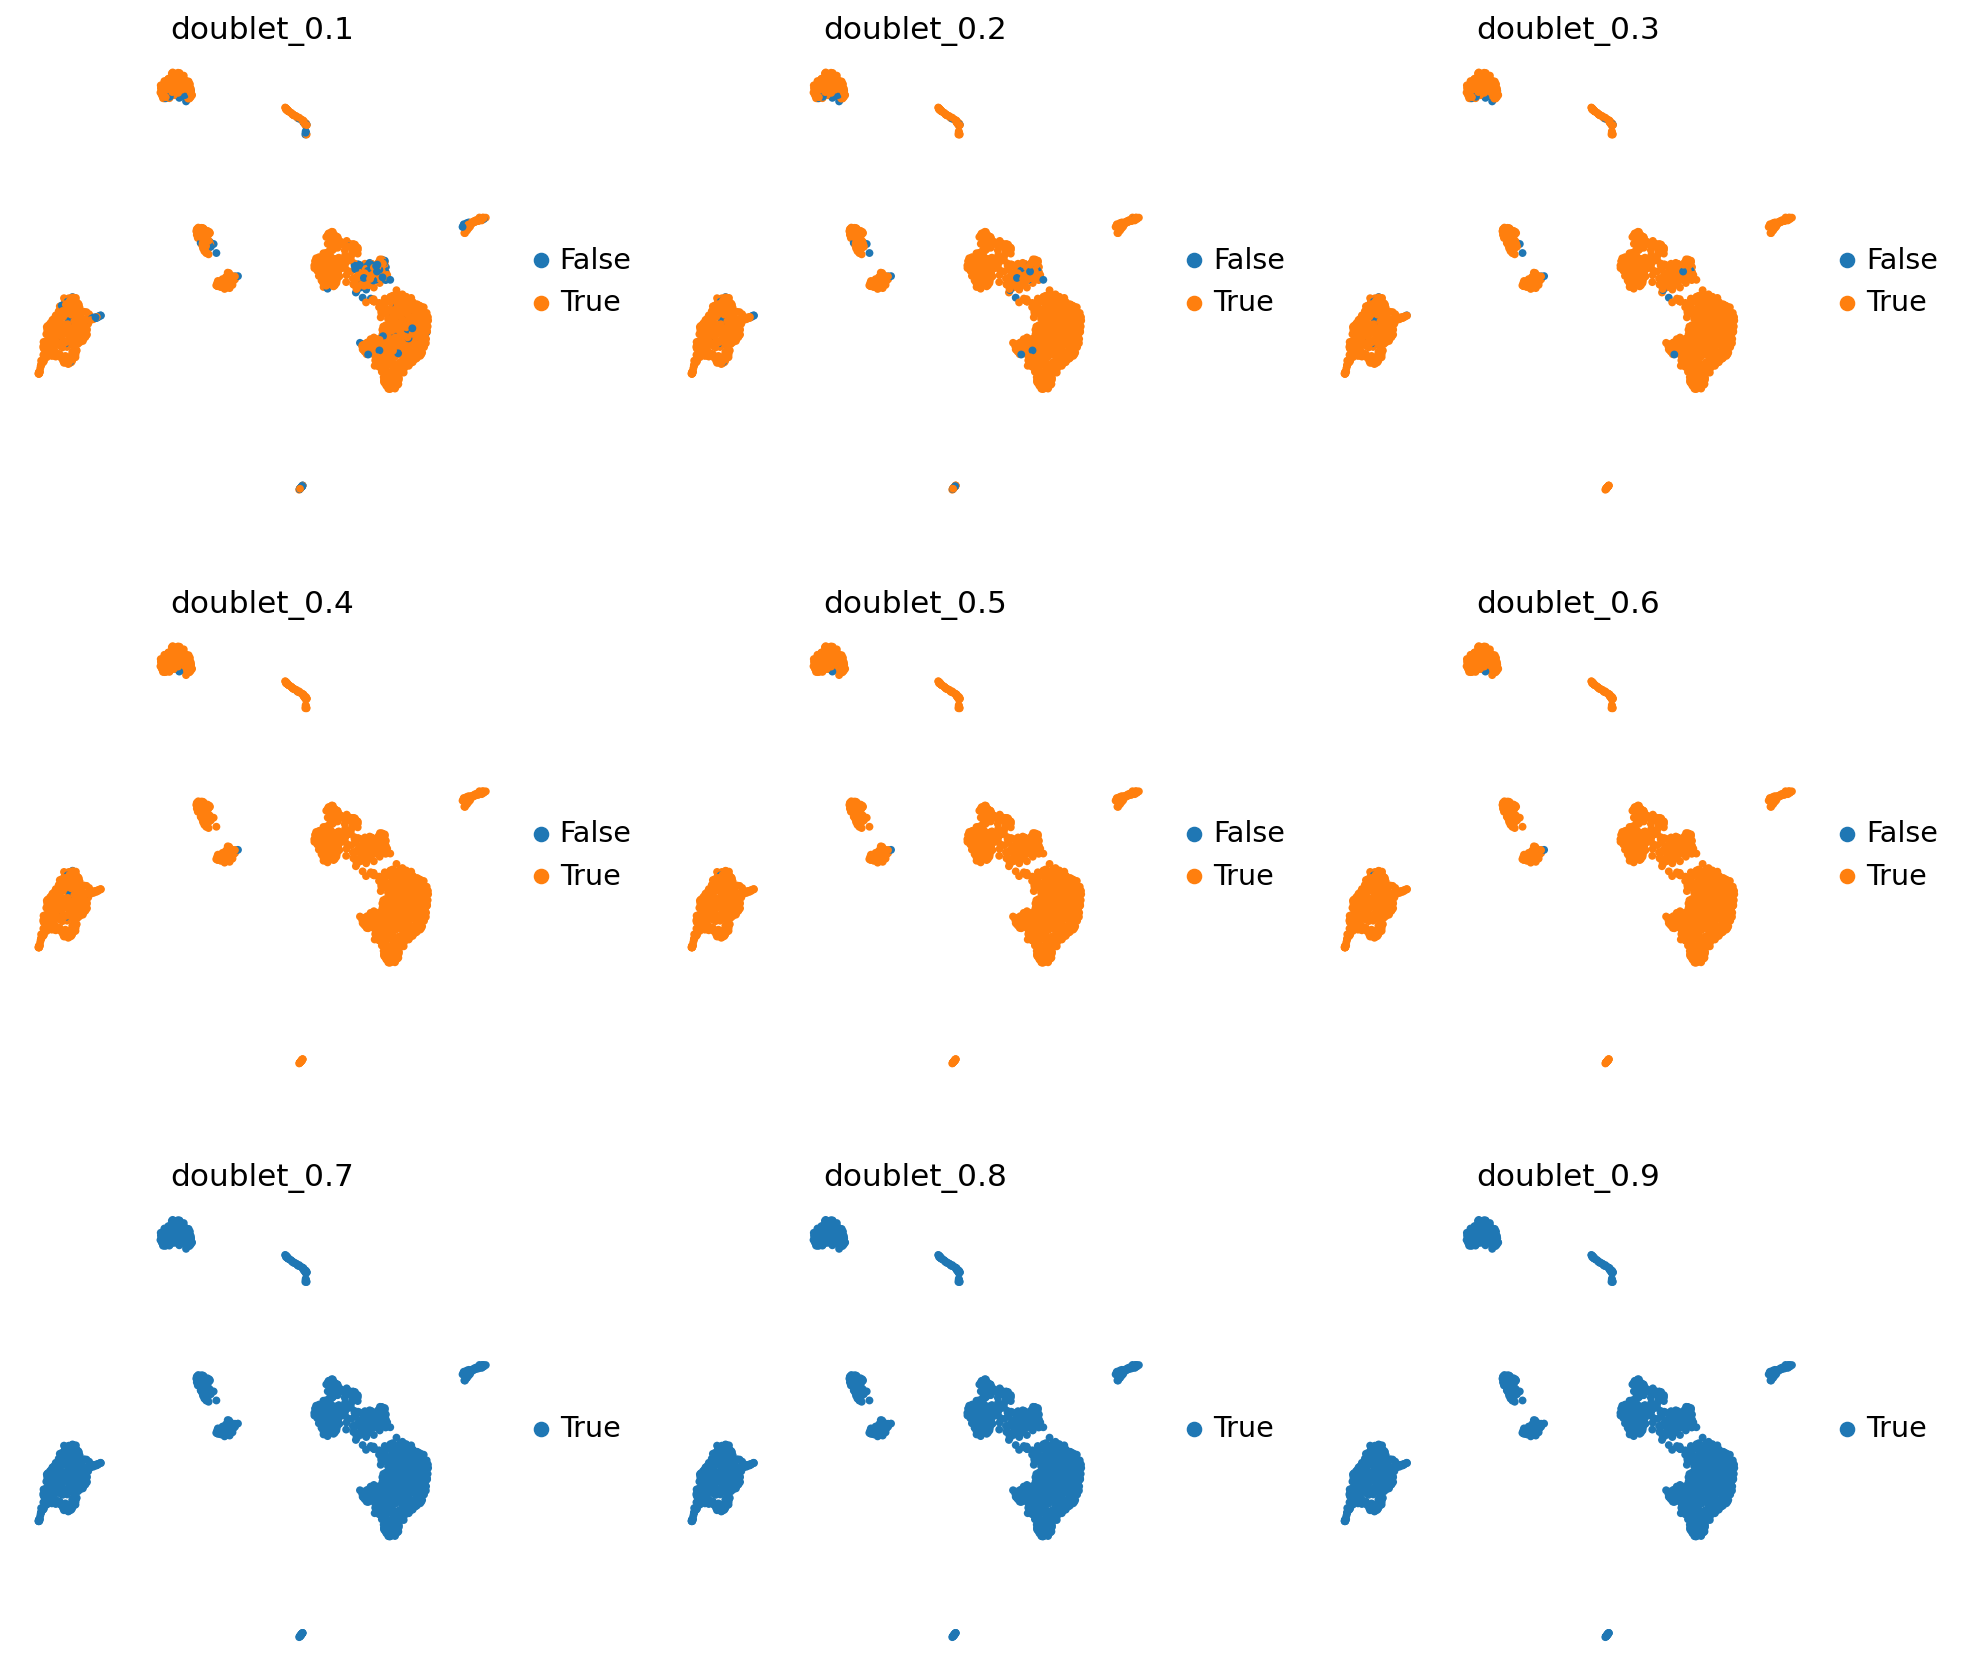

In [71]:
# for each bin, plot cells that are below the cutoff (True) and cells that are above (False)
sc.pl.umap(adata, color=[f'doublet_0.{i}' for i in range(1,10)], ncols=3, size=50)

In [72]:
# predicted doublet cells at each cutoff seem to be randomly distributed across clusters, rather than one cluster in particular
# use doublet score cutoff from Litvinukova et al (2020)
adata = adata[adata.obs['doublet_score'] < 0.3, :]

In [73]:
adata = adata.raw.to_adata()
adata.write('human_scrublet_processed_review.h5ad', compression='gzip')

In [74]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.0.1
annoy               NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
entrypoints         0.4
h5py                3.1.0
igraph              0.9.10
ipykernel           6.13.0
jedi                0.18.1
joblib              1.1.0
kiwisolver          1.3.2
leidenalg           0.8.8
llvmlite            0.38.0
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
natsort             8.1.0
nbinom_ufunc        NA
numba               0.55.1
numexpr             2.8.1
numpy               1.21.6
packaging           21.3
pandas              1.3.5
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.29
psutil              5.9.1
ptyprocess          0.7.0
pydev_ipy